In [3]:
import baptistLibrary as baptist
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings   
from dateutil.relativedelta import relativedelta 


warnings.filterwarnings("ignore")

In [4]:
if __name__ == "__main__":
    # Connect to the database
    connection = baptist.connect_to_oracle()
    query1 = """
    SELECT BUSINESS_UNIT AS "Unit", 
       DEPTID AS "Dept", 
       OPERATING_UNIT AS "Oper Unit",
       CONCAT( DEPTID,CONCAT( BUSINESS_UNIT, OPERATING_UNIT)) AS Concat,
       ACCOUNT AS "Account", 
       STATISTICS_CODE AS "Stat", 
       CURRENCY_CD AS "Currency", 
       FISCAL_YEAR AS "Year",
       accounting_period AS "Period",
       SUM(posted_total_amt) AS "Value"
    FROM PS_LEDGER
    WHERE ACCOUNT > '399999'
    AND FISCAL_YEAR BETWEEN EXTRACT(YEAR FROM SYSDATE) - 3 AND EXTRACT(YEAR FROM SYSDATE)
    AND ACCOUNTING_PERIOD < 13
    --AND business_unit = 20200
    AND DEPTID <> ' '
    AND CONCAT( DEPTID,CONCAT( BUSINESS_UNIT, OPERATING_UNIT)) IN (
    SELECT CONCAT( C.DEPTID,CONCAT( B.PARENT_NODE_NAME, B.TREE_NODE)) AS Concat
  FROM (PSTREENODE B LEFT OUTER JOIN  PS_OPER_UNIT_TBL E ON  E.EFFDT =
        (SELECT MAX(E_ED.EFFDT) FROM PS_OPER_UNIT_TBL E_ED
        WHERE E.SETID = E_ED.SETID
          AND E.OPERATING_UNIT = E_ED.OPERATING_UNIT
          AND E_ED.EFFDT <= SYSDATE) AND E.OPERATING_UNIT = substr( B.TREE_NODE,1,5) ), PS_DEPT_TBL C, PS_BUS_UNIT_TBL_FS D, PSTREELEAF A
  WHERE ( B.EFFDT =
        (SELECT MAX(B_ED.EFFDT) FROM PSTREENODE B_ED
        WHERE B.SETID = B_ED.SETID
          AND B.SETCNTRLVALUE = B_ED.SETCNTRLVALUE
          AND B.TREE_NAME = B_ED.TREE_NAME
          AND B_ED.EFFDT <= SYSDATE)
     AND B.TREE_NAME = 'BHMG_ORG_DEPT'
     AND C.EFFDT =
        (SELECT MAX(C_ED.EFFDT) FROM PS_DEPT_TBL C_ED
        WHERE C.SETID = C_ED.SETID
          AND C.DEPTID = C_ED.DEPTID
          AND C_ED.EFFDT <= SYSDATE)
     AND D.BUSINESS_UNIT = B.PARENT_NODE_NAME
     AND B.SETID = A.SETID
     AND B.SETCNTRLVALUE = A.SETCNTRLVALUE
     AND B.TREE_NAME = A.TREE_NAME
     AND B.TREE_NODE_NUM = A.TREE_NODE_NUM
     AND B.TREE_BRANCH = A.TREE_BRANCH
     AND A.EFFDT =
        (SELECT MAX(A_ED.EFFDT) FROM PSTREELEAF A_ED
        WHERE A.SETID = A_ED.SETID
          AND A.SETCNTRLVALUE = A_ED.SETCNTRLVALUE
          AND A.TREE_NAME = A_ED.TREE_NAME
          AND A_ED.EFFDT <= SYSDATE)
     AND C.DEPTID BETWEEN A.RANGE_FROM AND A.RANGE_TO
     AND C.EFF_STATUS = 'A'
     AND C.EFFDT =
        (SELECT MAX(C_ED.EFFDT) FROM PS_DEPT_TBL C_ED
        WHERE C.SETID = C_ED.SETID
          AND C.DEPTID = C_ED.DEPTID
          AND C_ED.EFFDT <= SYSDATE))
UNION
SELECT CONCAT(  H.DEPTID,CONCAT(substr(  I.TREE_NODE,1,5),' ')) AS Concat
  FROM PSTREELEAF F, PSTREENODE G, PS_TREE_NODE_TBL I, PS_DEPT_TBL H
  WHERE ( F.EFFDT =
        (SELECT MAX(F_ED.EFFDT) FROM PSTREELEAF F_ED
        WHERE F.SETID = F_ED.SETID
          AND F.SETCNTRLVALUE = F_ED.SETCNTRLVALUE
          AND F.TREE_NAME = F_ED.TREE_NAME
          AND F_ED.EFFDT <= SYSDATE)
     AND F.SETID = G.SETID
     AND F.SETCNTRLVALUE = G.SETCNTRLVALUE
     AND F.TREE_NAME = G.TREE_NAME
     AND F.TREE_NODE_NUM = G.TREE_NODE_NUM
     AND F.TREE_BRANCH = G.TREE_BRANCH
     AND G.EFFDT =
        (SELECT MAX(G_ED.EFFDT) FROM PSTREENODE G_ED
        WHERE G.SETID = G_ED.SETID
          AND G.SETCNTRLVALUE = G_ED.SETCNTRLVALUE
          AND G.TREE_NAME = G_ED.TREE_NAME
          AND G_ED.EFFDT <= SYSDATE)
     AND G.SETID = I.SETID
     AND G.TREE_NODE = I.TREE_NODE
     AND I.EFFDT =
        (SELECT MAX(I_ED.EFFDT) FROM PS_TREE_NODE_TBL I_ED
        WHERE I.SETID = I_ED.SETID
          AND I.TREE_NODE = I_ED.TREE_NODE
          AND I_ED.EFFDT <= SYSDATE)
     AND H.EFFDT =
        (SELECT MAX(H_ED.EFFDT) FROM PS_DEPT_TBL H_ED
        WHERE H.SETID = H_ED.SETID
          AND H.DEPTID = H_ED.DEPTID
          AND H_ED.EFFDT <= SYSDATE)
     AND H.DEPTID BETWEEN F.RANGE_FROM AND F.RANGE_TO
     AND H.EFF_STATUS = 'A'
     AND G.TREE_NAME = 'BHSF_BU_DEPT'
     AND substr(G.TREE_NODE,1,5) NOT IN ('42000','79200'))
    )
    GROUP BY business_unit,
         deptid,
         operating_unit,
         account,
         statistics_code,
         currency_cd,
         fiscal_year,
         accounting_period
        """
    if connection:
        queries = [query1]  # List of queries
        dataframes = baptist.execute_queries(connection, queries)  # Run queries and get DataFrames

        # Access the DataFrames
        df1 = dataframes.get('df1')  # DataFrame for query1
        #df2 = dataframes.get('df2')  # DataFrame for query2

        # Close the connection
        connection.close()

Connected to Oracle Database


In [ ]:
df1.info() #Checking the data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3872793 entries, 0 to 3872792
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Unit       object 
 1   Dept       object 
 2   Oper Unit  object 
 3   CONCAT     object 
 4   Account    object 
 5   Stat       object 
 6   Currency   object 
 7   Year       int64  
 8   Period     int64  
 9   Value      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 295.5+ MB


In [ ]:
df1 = df1.drop(['CONCAT'], axis=1) #Deleting Concat field

In [5]:
df1.head()

,Unit,Dept,Oper Unit,Account,Stat,Currency,Year,Period,Value
0,10000,10000,,612005,,USD,2021,6,-0.12
1,10000,10000,,612005,,USD,2021,12,-0.40
2,10000,10000,,614405,,USD,2021,1,0.00
3,10000,10000,,618010,,USD,2021,1,0.00
4,10000,10000,,618010,,USD,2021,2,0.00


In [23]:
df1 = df1.astype({'Unit': int, 'Dept': 'string', 'Oper Unit': 'string', 'Account': int, 'Stat': 'string', 'Currency': 'string'})

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861585 entries, 0 to 3861584
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Unit       int32  
 1   Dept       string 
 2   Oper Unit  string 
 3   Account    int32  
 4   Stat       string 
 5   Currency   string 
 6   Year       int64  
 7   Period     int64  
 8   Value      float64
dtypes: float64(1), int32(2), int64(2), string(4)
memory usage: 235.7 MB


In [25]:
df1.rename(columns={'Period' :'Months'}, inplace=True)

In [26]:
# Convert month number to name values (1 for October, 2 for November, etc.)
month_map_reverse = {
    1 : 'October', 2 : 'November', 3 : 'December',  4: 'January',
    5: 'February', 6 : 'March',  7: 'April',  8 : 'May',
     9: 'June',  10: 'July', 11 : 'August',  12 : 'September'
}

In [28]:
df1.head()

,Unit,Dept,Oper Unit,Account,Stat,Currency,Year,Months,Value
0,10000,10000,,612005,,USD,2021,6,-0.12
1,10000,10000,,612005,,USD,2021,12,-0.40
2,10000,10000,,614405,,USD,2021,1,0.00
3,10000,10000,,618010,,USD,2021,1,0.00
4,10000,10000,,618010,,USD,2021,2,0.00


In [29]:
df1['Months'] = df1['Months'].map(month_map_reverse)

In [30]:
df1.head()

,Unit,Dept,Oper Unit,Account,Stat,Currency,Year,Months,Value
0,10000,10000,,612005,,USD,2021,March,-0.12
1,10000,10000,,612005,,USD,2021,September,-0.40
2,10000,10000,,614405,,USD,2021,October,0.00
3,10000,10000,,618010,,USD,2021,October,0.00
4,10000,10000,,618010,,USD,2021,November,0.00


In [31]:
# Ensure Date is in datetime format
df1['Date'] = pd.to_datetime(df1['Year'].astype(str) + df1['Months'], format='%Y%B')

In [32]:
max_date = max(df1['Date'])

In [33]:
new_date = max_date - relativedelta(months = 3)

In [34]:
data = df1.query('Unit == 20200 & Date < @new_date')

In [35]:
data.head()

,Unit,Dept,Oper Unit,Account,Stat,Currency,Year,Months,Value,Date
513887,20200,10000,,618010,,USD,2021,October,0.0,2021-10-01
513888,20200,10000,,618010,,USD,2021,November,0.0,2021-11-01
513889,20200,10000,,618010,,USD,2021,December,0.0,2021-12-01
513890,20200,10000,,618010,,USD,2021,January,0.0,2021-01-01
513891,20200,10000,,618010,,USD,2021,February,0.0,2021-02-01


In [36]:
# Group the data by date and sum the values to aggregate any duplicates
grouped_data = data.groupby('Date').sum('value')

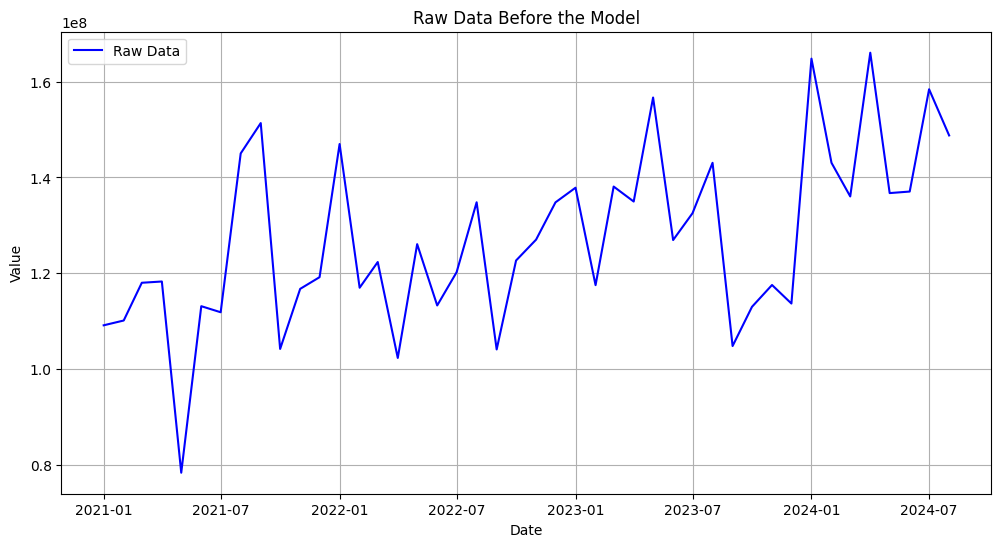

In [37]:
# Plotting the raw data before normalization
plt.figure(figsize=(12, 6))
plt.plot(grouped_data.index, grouped_data['Value'], label='Raw Data', color='blue')
plt.title('Raw Data Before the Model')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
# Convert month names to numerical values (1 for January, 2 for February, etc.)
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

In [39]:
# Apply the month mapping
data['Months'] = data['Months'].map(month_map)

In [40]:
# Grouping by the specified columns
grouped = data.groupby(['Unit', 'Dept', 'Oper Unit', 'Account', 'Stat', 'Currency'])

In [41]:
# Create a dictionary to store forecast results
prophet_results = []

In [42]:
# Forecasting for each group
for name, group in grouped:
    #print(f"Group name: {name})  # Debug: Print group name
    
    if group.empty:  # Check if group is empty
        print(f"Skipping group {name} because it is empty")
        continue
    
    group = group.sort_values('Date')  # Sort by time
    
    # Check if the 'Value' column has valid data
    if 'Value' not in group.columns or group['Value'].isnull().all():
        print(f"Skipping group {name} due to missing or invalid data in 'Value'")
        continue
    
    ts_data = group['Value'].values  # Extract time series data into an array
    
    if len(ts_data) == 0 or ts_data.ndim == 0:  # Check for empty or 0-dimensional array
        print(f"Skipping group {name} due to insufficient data")
        continue
    
    if len(ts_data) < 12:  # Skip groups with less than 12 months of data
        print(f"Skipping group {name} due to insufficient time series length")
        continue
    
    # Get the last year and month in the group (ensure they are integers)
    last_year = int(group['Year'].iloc[-1])
    last_month = int(group['Months'].iloc[-1])

    try:
         # Prepare data for Prophet
        prophet_df = group[['Date', 'Value']].rename(columns={'Date': 'ds', 'Value': 'y'})
        
        # Initialize and fit the model
        model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
        model_prophet.fit(prophet_df)
        
        # Create future dates for the next 24 months
        future = model_prophet.make_future_dataframe(periods=24, freq='M')
        
        # Forecast for the next 24 months
        forecast_prophet = model_prophet.predict(future)
        
        # Extract Prophet forecast results for the 24 months (ignoring the past)
        forecast_prophet_filtered = forecast_prophet[['ds', 'yhat']].iloc[-24:]
        
        # Append Prophet forecast results
        for index, row in forecast_prophet_filtered.iterrows():
            prophet_results.append({
                'Unit': name[0],
                'Department': name[1],
                'Operating Unit': name[2],
                'Account': name[3],
                'Stat': name[4],
                'Currency': name[5],
                'Year': row['ds'].year,
                'Months': row['ds'].month,
                'Forecast_Prophet': row['yhat']
            })
    except Exception as e:
        print(f"Prophet failed for group {name}: {e}")
        continue

In [43]:
# Convert forecast results to a DataFrame
forecast_df = pd.DataFrame(prophet_results)

In [44]:
# Convert month number to name values (1 for January, 2 for February, etc.)
month_map_reverse = {
    1 : 'January', 2 : 'February', 3 : 'March',  4: 'April',
    5: 'May', 6 : 'June',  7: 'July',  8 : 'August',
     9: 'September',  10: 'October', 11 : 'November',  12 : 'December'
}

In [45]:
# Apply the month mapping
forecast_df['Months'] = forecast_df['Months'].map(month_map_reverse)
#forecast_outliers['Month'] = forecast_outliers['Month'].map(month_map_reverse)

In [46]:
forecast_df.head()

,Unit,Department,Operating Unit,Account,Stat,Currency,Year,Months,Forecast_Prophet
0,20200,10000,,618010,,USD,2024,August,596.636222
1,20200,10000,,618010,,USD,2024,September,127.029711
2,20200,10000,,618010,,USD,2024,October,88.865772
3,20200,10000,,618010,,USD,2024,November,-133.443276
4,20200,10000,,618010,,USD,2024,December,-132.064184


In [47]:
data['Months'] = data['Months'].map(month_map_reverse)
data.head()

,Unit,Dept,Oper Unit,Account,Stat,Currency,Year,Months,Value,Date
513887,20200,10000,,618010,,USD,2021,October,0.0,2021-10-01
513888,20200,10000,,618010,,USD,2021,November,0.0,2021-11-01
513889,20200,10000,,618010,,USD,2021,December,0.0,2021-12-01
513890,20200,10000,,618010,,USD,2021,January,0.0,2021-01-01
513891,20200,10000,,618010,,USD,2021,February,0.0,2021-02-01


In [48]:
# Ensure Date is in datetime format
forecast_df['Date'] = pd.to_datetime(forecast_df['Year'].astype(str) + forecast_df['Months'], format='%Y%B')
data['Date'] = pd.to_datetime(data['Year'].astype(str) + data['Months'], format='%Y%B')

In [49]:
# Group the data by date and sum the values to aggregate any duplicates
grouped_data_forecast = forecast_df.groupby('Date').sum('value')
grouped_data_compare = data.groupby('Date').sum('value')

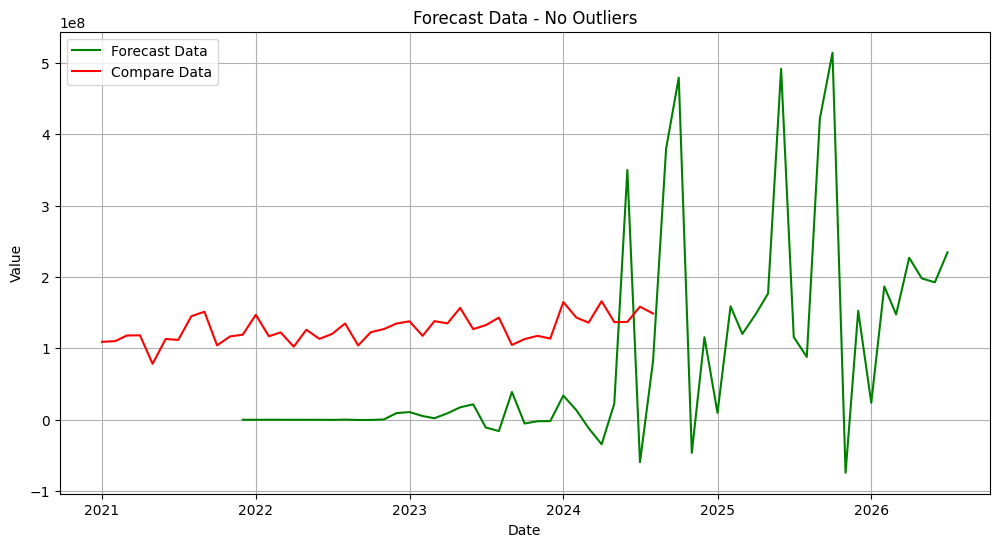

In [50]:
# Plotting the raw data before normalization
plt.figure(figsize=(12, 6))
plt.plot(grouped_data_forecast.index, grouped_data_forecast['Forecast_Prophet'], label='Forecast Data', color='green')
plt.plot(grouped_data_compare.index, grouped_data_compare['Value'], label='Compare Data', color='red')
plt.title('Forecast Data - No Outliers')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [51]:
forecast_pivot = forecast_df.pivot_table(
    index=['Unit', 'Department', 'Operating Unit', 'Account', 'Stat', 'Currency', 'Year'],
    columns='Months',
    values='Forecast_Prophet'
)

In [52]:
forecast_df.head()

,Unit,Department,Operating Unit,Account,Stat,Currency,Year,Months,Forecast_Prophet,Date
0,20200,10000,,618010,,USD,2024,August,596.636222,2024-08-01
1,20200,10000,,618010,,USD,2024,September,127.029711,2024-09-01
2,20200,10000,,618010,,USD,2024,October,88.865772,2024-10-01
3,20200,10000,,618010,,USD,2024,November,-133.443276,2024-11-01
4,20200,10000,,618010,,USD,2024,December,-132.064184,2024-12-01


In [53]:
forecast_pivot.head()

Months                                                            April  \
Unit  Department Operating Unit Account Stat Currency Year                
20200 10000                     618010       USD      2024          NaN   
                                                      2025  2014.128031   
                                                      2026  2678.924041   
                                618015       USD      2024          NaN   
                                                      2025     0.000000   

Months                                                          August  \
Unit  Department Operating Unit Account Stat Currency Year               
20200 10000                     618010       USD      2024  596.636222   
                                                      2025  894.566923   
                                                      2026         NaN   
                                618015       USD      2024    0.000000   
                                                      2025    0.000000   

Months                                                        December  \
Unit  Department Operating Unit Account Stat Currency Year               
20200 10000                     618010       USD      2024 -132.064184   
                                                      2025 -187.669561   
                                                      2026         NaN   
                                618015       USD      2024    0.000000   
                                                      2025    0.000000   

Months                                                         February  \
Unit  Department Operating Unit Account Stat Currency Year                
20200 10000                     618010       USD      2024          NaN   
                                                      2025  1510.942972   
                                                      2026  2115.795257   
                                618015       USD      2024          NaN   
                                                      2025     0.000000   

Months                                                          January  \
Unit  Department Operating Unit Account Stat Currency Year                
20200 10000                     618010       USD      2024          NaN   
                                                      2025 -1101.396394   
                                                      2026 -1424.784363   
                                618015       USD      2024          NaN   
                                                      2025     0.000000   

Months                                                            July  \
Unit  Department Operating Unit Account Stat Currency Year               
20200 10000                     618010       USD      2024         NaN   
                                                      2025  490.954933   
                                                      2026  669.891564   
                                618015       USD      2024         NaN   
                                                      2025    0.000000   

Months                                                             June  \
Unit  Department Operating Unit Account Stat Currency Year                
20200 10000                     618010       USD      2024          NaN   
                                                      2025   779.283286   
                                                      2026  1054.770382   
                                618015       USD      2024          NaN   
                                                      2025     0.000000   

Months                                                           March  \
Unit  Department Operating Unit Account Stat Currency Year               
20200 10000                     618010       USD      2024         NaN   
                                                      2025 -277.425762   
                                           

In [54]:
# Save to CSV
forecast_pivot.to_csv('Prhophet_pivot_forecast.csv', index=True)

In [72]:
forecast_df.to_csv('Prhophet_forecast.csv', index=True)